# FEATURE TRANSFORMATION

Feature tansformation adalah fungsi yang digunkan untuk merubah *feature* dari satu repesentasi ke representasi lainnnya. Beberapa sebab kita harus merubah *feature*, diantaranya :
1. Tipe data tidak sesuai dengan algoritma *machine learning*, contoh : text, kategori.
2. Nilai dari *feature* mungkin menimbulkan masalah dalam proses *learning*, contoh : skalanya berbeda.
3. Mengurangi jumlah *feature* untuk mem-plot dan memvisualisasikan data, meningkatkan kecepatan training atau meningkatkan akurasi dari model tertentu.

## Daftar Isi  :
### 1. Penanganan Variabel Berbentuk Kaegori.
### 2. Penskalaan *Feature*
### 3. Dasar Analisis Komponen

#### Pendahuluan/Persiapan
Membuat tampilan tabel dapat di-*scroll* horizontal agar lebih rapi.

In [1]:
from IPython.display import display, HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

## 1. Penanganan Variabel berbentuk Kategori

#### Variabel berbentuk Kategori
Dapat dikelompokan menjadi dua tipe, yaitu :
1. Nominal --> tidak dapat diurutkan, contoh : gender, warna.
2. Ordinal --> dapat diurutkan, contoh : ukuran baju, ranking, nilai.

Machine Learning tidak dapat menangani data berbentuk kategori sehingga perlu dirubah menjadi nilai dengan format yang lebih relevan.

#### Menyiapkan *Environment* : import pyspark, membuat *spark session*, dan memuat serta menampilakn data

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
data = spark.read.csv('./colors.csv', header=True, inferSchema=True)
data.show()

+---+------+
| id| color|
+---+------+
|  1|   red|
|  2|  blue|
|  3|orange|
|  4| white|
|  5|   red|
|  6|orange|
|  7|   red|
|  8| white|
|  9|   red|
+---+------+



Dikarenakan data tersebut berbentuk kategori, sehingga perlu merubah formatnya. Kita akan mengubahnya dengan metode :
### a. Indexing
### b. One Hot Encoding
# ---------------------------------------------------------------------------

### a. String Indexing
--> Mengubah kategori menjadi angka.

Pertama, definisikan StringIndexer.

In [3]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="color", outputCol="color_indexed")

Selanjutnya, panggil metode fit() untuk menginisiasi proses *learning*.
Nilai kembalian dari indexer_model adalah sebuah objek bertipe **Transformer**.

In [4]:
indexer_model = indexer.fit(data)

Setelah itu, melakukan transformasi dengan memanggil transform().
Dapat dilihat kolom 'color_indexed' sudah ditambahkan.

In [5]:
indexed_data= indexer_model.transform(data)
# Menampilkan data
indexed_data.show()

+---+------+-------------+
| id| color|color_indexed|
+---+------+-------------+
|  1|   red|          0.0|
|  2|  blue|          3.0|
|  3|orange|          1.0|
|  4| white|          2.0|
|  5|   red|          0.0|
|  6|orange|          1.0|
|  7|   red|          0.0|
|  8| white|          2.0|
|  9|   red|          0.0|
+---+------+-------------+



Akan tetapi, masih terdapat masalah yaitu angka tersebut terkesan ordinal. Oleh karena itu, kita dapat menggunkan teknik lain yaitu **One Hot Encoding**.

### b. One Hot Encoding

Supaya kategori data tidak terkesan berurutan, kita melakukan :
1. Memecah kolom kategori menjadi sebanyak n kolom. Dimana n merupakan jumlah dari kategori unik di dalam kolom awal.
2. Men-*assign* nilai binari kepada setiap kolom yang merepresentasikan keberadaan dari warna dari data.

Pertama, import OneHotEncoder dan buat sebuah variabel estimator.

In [6]:
from pyspark.ml.feature import OneHotEncoder
ohe = OneHotEncoder(inputCols=["color_indexed"], outputCols=["color_ohe"])

Sekarang, kita melatih estimator pada data untuk mempelajari berapa banyak kategori yang perlu di-encode.

In [7]:
ohe_model = ohe.fit(indexed_data)

Saatnya mengaplikasikan pada data.

In [8]:
encoded_data = ohe_model.transform(indexed_data)
encoded_data.show()

+---+------+-------------+-------------+
| id| color|color_indexed|    color_ohe|
+---+------+-------------+-------------+
|  1|   red|          0.0|(3,[0],[1.0])|
|  2|  blue|          3.0|    (3,[],[])|
|  3|orange|          1.0|(3,[1],[1.0])|
|  4| white|          2.0|(3,[2],[1.0])|
|  5|   red|          0.0|(3,[0],[1.0])|
|  6|orange|          1.0|(3,[1],[1.0])|
|  7|   red|          0.0|(3,[0],[1.0])|
|  8| white|          2.0|(3,[2],[1.0])|
|  9|   red|          0.0|(3,[0],[1.0])|
+---+------+-------------+-------------+



Kolom tersebut merepresentasikan DenseVektor dari tipe data yang digunakan untuk mengurangi penyimpanan. 
Contohnya (3,[0],[1]) :
3 --> kita memiliki array dengan 3 nilai, dimana kita memiliki nilai 1 pada index 0 dan nilai 0 pada indeks lainnya.

##### OPTIONAL

--> Anda bisa mengisi parameter, dropLast=False jika ingin Spark tidak menghilangkan kolom terakhirnya.

In [9]:
ohe = OneHotEncoder(inputCols=["color_indexed"], outputCols=["color_ohe"], dropLast=False)

## 2. Feature Scaling
Feature Scaling berfungsi untuk menormalisasikan data agar tidak ada data yang mendominasi dari data lain pada algoritma tertentu, contohnya KMeans.
Kali ini kita akan bekerja pada dataset 'Wine'.

In [10]:
data = spark.read.csv('./wine.data', header=False, inferSchema=True)
data.show()

+---+-----+----+----+----+---+----+----+----+----+----+----+----+----+
|_c0|  _c1| _c2| _c3| _c4|_c5| _c6| _c7| _c8| _c9|_c10|_c11|_c12|_c13|
+---+-----+----+----+----+---+----+----+----+----+----+----+----+----+
|  1|14.23|1.71|2.43|15.6|127| 2.8|3.06|0.28|2.29|5.64|1.04|3.92|1065|
|  1| 13.2|1.78|2.14|11.2|100|2.65|2.76|0.26|1.28|4.38|1.05| 3.4|1050|
|  1|13.16|2.36|2.67|18.6|101| 2.8|3.24| 0.3|2.81|5.68|1.03|3.17|1185|
|  1|14.37|1.95| 2.5|16.8|113|3.85|3.49|0.24|2.18| 7.8|0.86|3.45|1480|
|  1|13.24|2.59|2.87|21.0|118| 2.8|2.69|0.39|1.82|4.32|1.04|2.93| 735|
|  1| 14.2|1.76|2.45|15.2|112|3.27|3.39|0.34|1.97|6.75|1.05|2.85|1450|
|  1|14.39|1.87|2.45|14.6| 96| 2.5|2.52| 0.3|1.98|5.25|1.02|3.58|1290|
|  1|14.06|2.15|2.61|17.6|121| 2.6|2.51|0.31|1.25|5.05|1.06|3.58|1295|
|  1|14.83|1.64|2.17|14.0| 97| 2.8|2.98|0.29|1.98| 5.2|1.08|2.85|1045|
|  1|13.86|1.35|2.27|16.0| 98|2.98|3.15|0.22|1.85|7.22|1.01|3.55|1045|
|  1| 14.1|2.16| 2.3|18.0|105|2.95|3.32|0.22|2.38|5.75|1.25|3.17|1510|
|  1|1

In [11]:
data.describe().show() 

+-------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-------------------+------------------+-----------------+-------------------+------------------+-----------------+
|summary|               _c0|               _c1|               _c2|               _c3|              _c4|               _c5|               _c6|               _c7|                _c8|               _c9|             _c10|               _c11|              _c12|             _c13|
+-------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-------------------+------------------+-----------------+-------------------+------------------+-----------------+
|  count|               178|               178|               178|               178|              178|               178|               178|               178|               

Mari kita lihat dataset kita. Dari hasil deskripsi tersebut dapat dilihat ke-inkonsistenan dalam skalanya.

*Scalers* diaplikasikan pada *Data Tipe Vektor*. Oleh karena itu, kita perlu mengumpulkan *feature* menggunakan **VectorAssembler** terlebih dahulu.

Catatan : kita menghilangkan kolom _c0 dikarenakan kolom tersebut adalah kolom kategorikal.

### a. StandardScaler
Metode ini melakukan standarisasi dari *feature*.
Metode ini dilakukan dengan menghilangkan rata-rata dan melakukan pen-skalan ke unit standar deviasi dengan menggunakan *collumn-summary-statistics.*

In [12]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=data.columns[1:], outputCol="features")
data_2 = assembler.transform(data)

Dua parameter yang opsional yang dapat diambil :
1. *withStd*: Men-skalakan data ke dalam unit standar deviasi. Dafult = True.
2. *withMean*: Menengahkan data dengan rata-rata sebelum melakukan pen-skalaan..

Untuk mendefinisikan StandardScaler :

In [13]:
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

Sekarang, mari memasang estimator kita ke dalam dataset.

In [14]:
scaler_model = scaler.fit(data_2)

Akhirnya kita bisa mengaplikasikan transformasi kita pada data.

In [15]:
scaled_data = scaler_model.transform(data_2)

### b. MinMaxScaler
Sama seperti proses nomor satu, tetapi dengan nama kelas dan parameter yang berbeda.
**MinMaxScaler** merubah nilai data ke dalam *range* spesifik ([0,1]) sebagai defaultnya.

In [16]:
from pyspark.ml.feature import MinMaxScaler
scaler = MinMaxScaler(min=0, max=1, inputCol='features', outputCol='features_minmax')
scaler_model = scaler.fit(data_2)
data_3 = scaler_model.transform(data_2)

## 3. Dasar Analisis Komponen (Principal Component Analysis/PCA)
**PCA** Merupakan sebuah prosedur yang mengonversi serangkaian observasi dari m menjadi n dimensi (dimana m>n). setalah menganalisis *feature* yang berkorelasi dalam variabel. Metode ini biasanya digunakan untuk visualisasi atau pengurangan dimensi.
Cara menerapkan PCA sama dengan menerapkan estimator lainnya.
1. Buat sebuah estimator.
2. Pasang estimator pada model untuk mendapatkan *transformer*.
3. Aplikasikan *transformer* pada data.

Mari mengaplikasikan PCA pada dataset dari gambar tulisan tangan. Data tersebut memiliki 785 kolom. 
Sekarang kita dapat merubahnya menjadi 2 dimensi dengan menggunakan PCA.

Pertama, mari membaca data dan mengumpulkan pixel-pixenya ke dalam kolom *feature*.

In [17]:
data = spark.read.csv('./digits.csv', header=True, inferSchema=True)
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=data.columns[1:], outputCol='features')
data_2 = assembler.transform(data)

Kita membuat PCA model kita dengan k = 2 (banyaknya dimensi output).

In [18]:
from pyspark.ml.feature import PCA
pca = PCA(k=2, inputCol='features', outputCol='features_pca')

KIta men-*train* estimator.

In [19]:
pca_model = pca.fit(data_2)

Terakhir, kita mengaplikasikan model pada data.

In [20]:
pca_data = pca_model.transform(data_2).select('features_pca')
pca_data.show()

+--------------------+
|        features_pca|
+--------------------+
|[103.738813757982...|
|[2466.78627830941...|
|[-121.55984060478...|
|[599.578991071953...|
|[2689.04430947598...|
|[1253.08650413365...|
|[93.0114290617962...|
|[650.952778816163...|
|[1115.56395904828...|
|[1062.72668192116...|
|[1029.01690081557...|
|[458.805321389768...|
|[-200.34133976162...|
|[751.263926957183...|
|[1265.44211418056...|
|[-199.11010313256...|
|[762.715694923041...|
|[1744.79986516159...|
|[128.314928856543...|
|[1731.44148649029...|
+--------------------+
only showing top 20 rows



Sekarang mari kita ubah data kita menjadi pandas dataframe dan memvisualisasikannya.

                                    features_pca
0        [103.73881375798244, 699.5124334036431]
1         [2466.786278309411, 360.7526613889307]
2      [-121.55984060478046, 293.96688737760746]
3       [599.5789910719535, -299.98165533942404]
4         [2689.044309475987, 449.3541744175658]
...                                          ...
41995    [1525.689872940072, 250.05532485154546]
41996    [-294.538589480864, 302.49345587128744]
41997   [1101.6045752108482, -949.8141750943781]
41998   [1092.7339850472454, -61.81498424651614]
41999    [401.085393632208, -418.69192126048745]

[42000 rows x 1 columns]


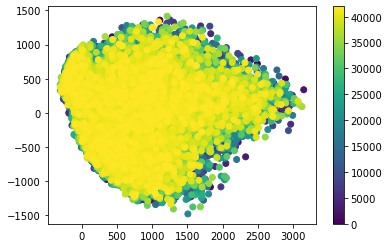

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

pandasDf = pca_data.toPandas()
print(pandasDf)

x_values = [point[0] for point in pandasDf['features_pca']]
y_values = [point[1] for point in pandasDf['features_pca']]

colors = range(len(x_values))
plt.scatter(x=x_values, y=y_values, c=colors)

plt.colorbar()

# Show the plot
plt.show()

### Kesimpulan
Kita sudah belajar tiga teknik untuk merubah data menjadi data yang lebih relevan dan optimal untuk algorimta *machine learning*.